In [3]:
%matplotlib inline


Transfer Learning for Custom Object Detection on Mobile
==============================================

In this notebook you will,

1. Connect to your drive
2. Create your own dataset using your camera (without leaving colab)
3. Train a classifier on top of pretrained mobilenetv3
4. Deploy your trained custom model for Lite Interpreter
5. Use the model on Android mobile app

_This tutorial is a modified version of [PyTorch's Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)_


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Create Your Custom Dataset
---------

Take photos using the camera (tested on Chrome)


In [5]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Change the following code for the categories and train/val sets. I captured 30 images for training and 10 more challenging images for validation set.

In [15]:
from IPython.display import Image

# complete this step for Training and Validation categories
for i in range(10):
    try:
        photo_url = "/content/drive/MyDrive/datasets/val/down/down{}.jpg".format(i);
        filename = take_photo(filename=photo_url)
        print('Saved to {}'.format(filename))
        i+=1
        # Show the image which was just taken.
        #display(Image(filename))
    except Exception as err:
        # Errors will be thrown if the user does not have a webcam or if they do not
        # grant the page permission to access it.
        print(str(err))

<IPython.core.display.Javascript object>

Saved to /content/drive/MyDrive/datasets/val/down/down0.jpg


<IPython.core.display.Javascript object>

Saved to /content/drive/MyDrive/datasets/val/down/down1.jpg


<IPython.core.display.Javascript object>

Saved to /content/drive/MyDrive/datasets/val/down/down2.jpg


<IPython.core.display.Javascript object>

Saved to /content/drive/MyDrive/datasets/val/down/down3.jpg


<IPython.core.display.Javascript object>

Saved to /content/drive/MyDrive/datasets/val/down/down4.jpg


<IPython.core.display.Javascript object>

Saved to /content/drive/MyDrive/datasets/val/down/down5.jpg


<IPython.core.display.Javascript object>

Saved to /content/drive/MyDrive/datasets/val/down/down6.jpg


<IPython.core.display.Javascript object>

Saved to /content/drive/MyDrive/datasets/val/down/down7.jpg


<IPython.core.display.Javascript object>

Saved to /content/drive/MyDrive/datasets/val/down/down8.jpg


<IPython.core.display.Javascript object>

Saved to /content/drive/MyDrive/datasets/val/down/down9.jpg


In [24]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/datasets/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Visualize some of the captured and transformed images:



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


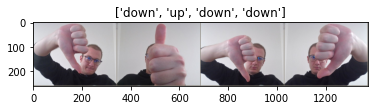

In [25]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions



In [27]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.  You can read more about this in the documentation at https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward.




In [28]:
model_conv = torchvision.models.mobilenet_v3_large(pretrained=True, width_mult=1.0,  reduced_tail=False, dilated=False)
model_conv

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=

In [29]:
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[0].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_conv.classifier = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [30]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6632 Acc: 0.6000
val Loss: 0.5911 Acc: 0.8500

Epoch 1/24
----------
train Loss: 0.5285 Acc: 0.6333
val Loss: 0.4607 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.4142 Acc: 0.7833
val Loss: 0.3585 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.2849 Acc: 0.9500
val Loss: 0.2864 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.2501 Acc: 0.9500
val Loss: 0.2224 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.2693 Acc: 0.8833
val Loss: 0.2097 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.1960 Acc: 0.9667
val Loss: 0.1489 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.2302 Acc: 0.9333
val Loss: 0.1378 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.2172 Acc: 0.9333
val Loss: 0.1318 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.1694 Acc: 0.9667
val Loss: 0.1313 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.1893 Acc: 0.9833
val Loss: 0.1347 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.2106 Acc: 0.9500
val Loss: 0.1344 Acc: 1.0000

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


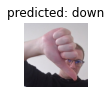

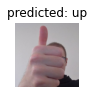

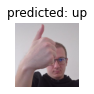

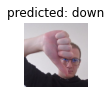

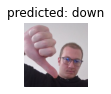

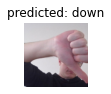

In [31]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Mobile Optimization
-----------------

In [32]:
from torch.utils.mobile_optimizer import optimize_for_mobile

You can use already available pretrained models from PyTorch's models repository: https://pytorch.org/vision/stable/models.html

In [ ]:
#model = torchvision.models.mobilenet_v2(pretrained=True)
model = torchvision.models.resnet18(pretrained=True)
model.eval()
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model, example)
traced_script_module_optimized = optimize_for_mobile(traced_script_module)
traced_script_module_optimized._save_for_lite_interpreter("resnet18.ptl")

In a similar way, let's save the model optimized code for the Mobile Lite Interpreter.

In [35]:
scripted_module = torch.jit.script(model_conv)
# Export full jit version model (not compatible mobile interpreter), leave it here for comparison
scripted_module.save("mobilenetv3_custom.pt")
# Export mobile interpreter version model (compatible with mobile interpreter)
optimized_scripted_module = optimize_for_mobile(scripted_module)
optimized_scripted_module._save_for_lite_interpreter("mobilenetv3_custom.ptl")